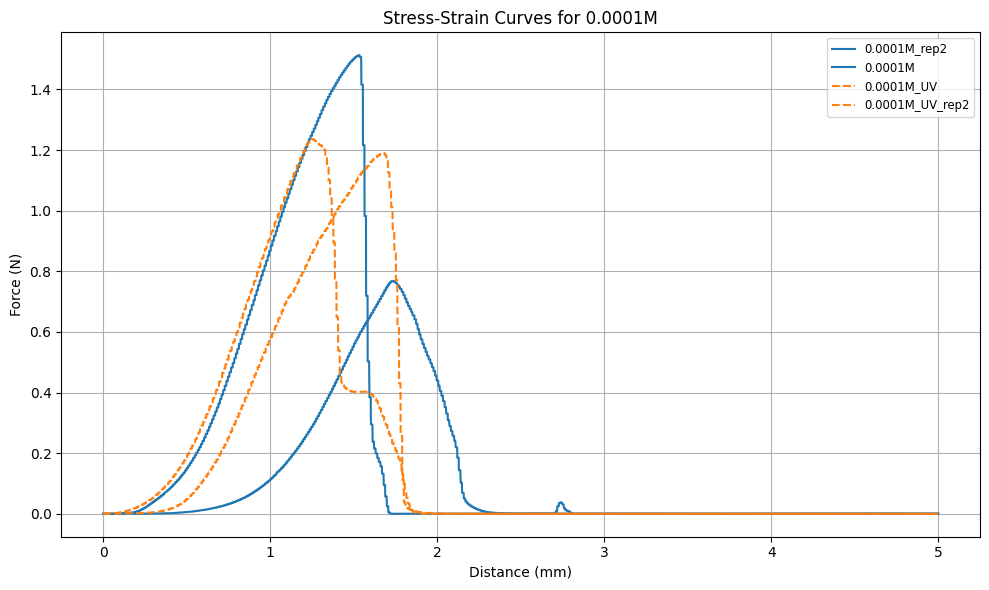

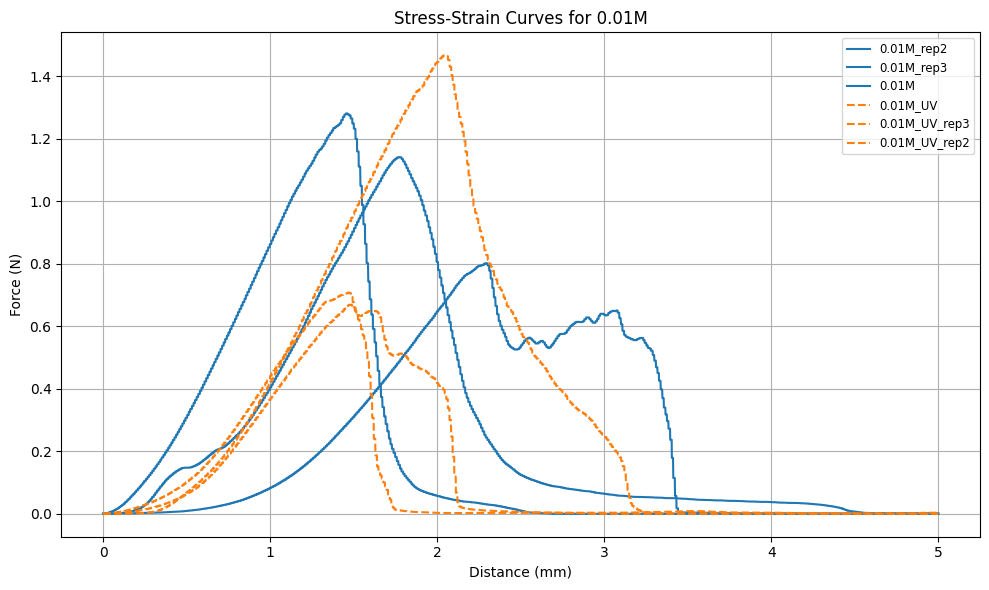

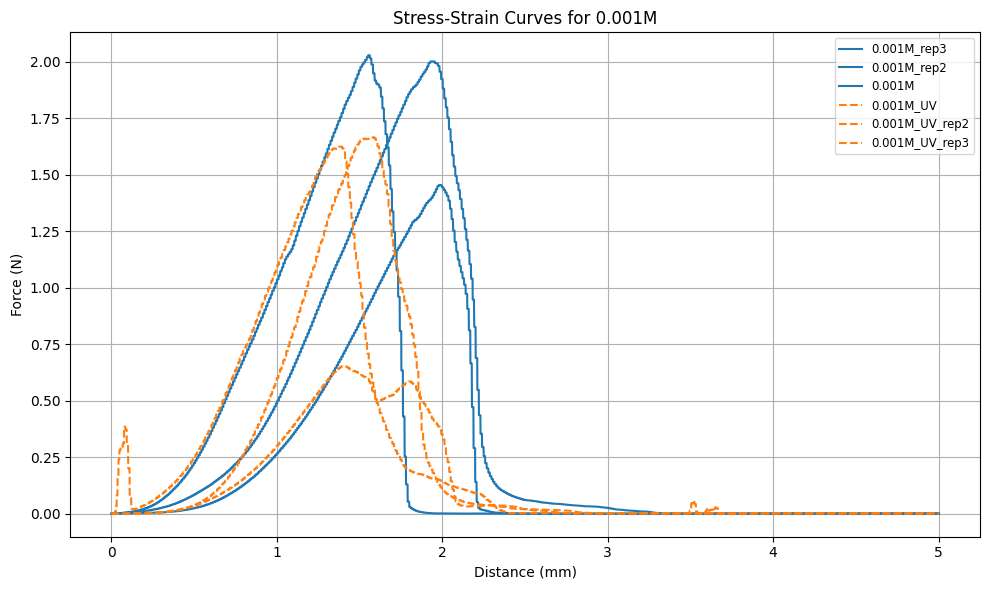

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from collections import defaultdict

# Set your folder path
folder_path = '07.10.25_thiol_glucose_experiments'
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

def clean_name(filename):
    base = os.path.basename(filename).replace('.csv', '')
    return base.replace('07.10.25_krha-', '')

# Step 1: Group files by full condition (with or without UV)
condition_files = defaultdict(list)
for file in csv_files:
    name = clean_name(file)
    condition = name.split('_rep')[0]  # base condition, e.g. "0.001M", "0.001M_UV"
    condition_files[condition].append((file, name))

# Step 2: Group conditions by base concentration (e.g., "0.001M")
base_groups = defaultdict(dict)
for condition in condition_files:
    if condition.endswith('_UV'):
        base = condition.replace('_UV', '')
        base_groups[base]['UV'] = condition_files[condition]
    else:
        base = condition
        base_groups[base]['Normal'] = condition_files[condition]

# Step 3: Plot one figure per base concentration
for base_conc, cond_dict in base_groups.items():
    plt.figure(figsize=(10, 6))
    
    # Plot normal condition if it exists
    if 'Normal' in cond_dict:
        for file, label in cond_dict['Normal']:
            df = pd.read_csv(file)
            df['Force (Newtons)'] = df['Force (Newtons)'].clip(lower=0)
            plt.plot(df['Distance (millimeters)'], df['Force (Newtons)'],
                     label=f"{label}", linestyle='-', color='tab:blue')

    # Plot UV condition if it exists
    if 'UV' in cond_dict:
        for file, label in cond_dict['UV']:
            df = pd.read_csv(file)
            df['Force (Newtons)'] = df['Force (Newtons)'].clip(lower=0)
            plt.plot(df['Distance (millimeters)'], df['Force (Newtons)'],
                     label=f"{label}", linestyle='--', color='tab:orange')

    plt.xlabel('Distance (mm)')
    plt.ylabel('Force (N)')
    plt.title(f'Stress-Strain Curves for K. Rhaeticus Cellulose Cultured with {base_conc} of Thiol Glucose')
    plt.legend(fontsize='small', loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


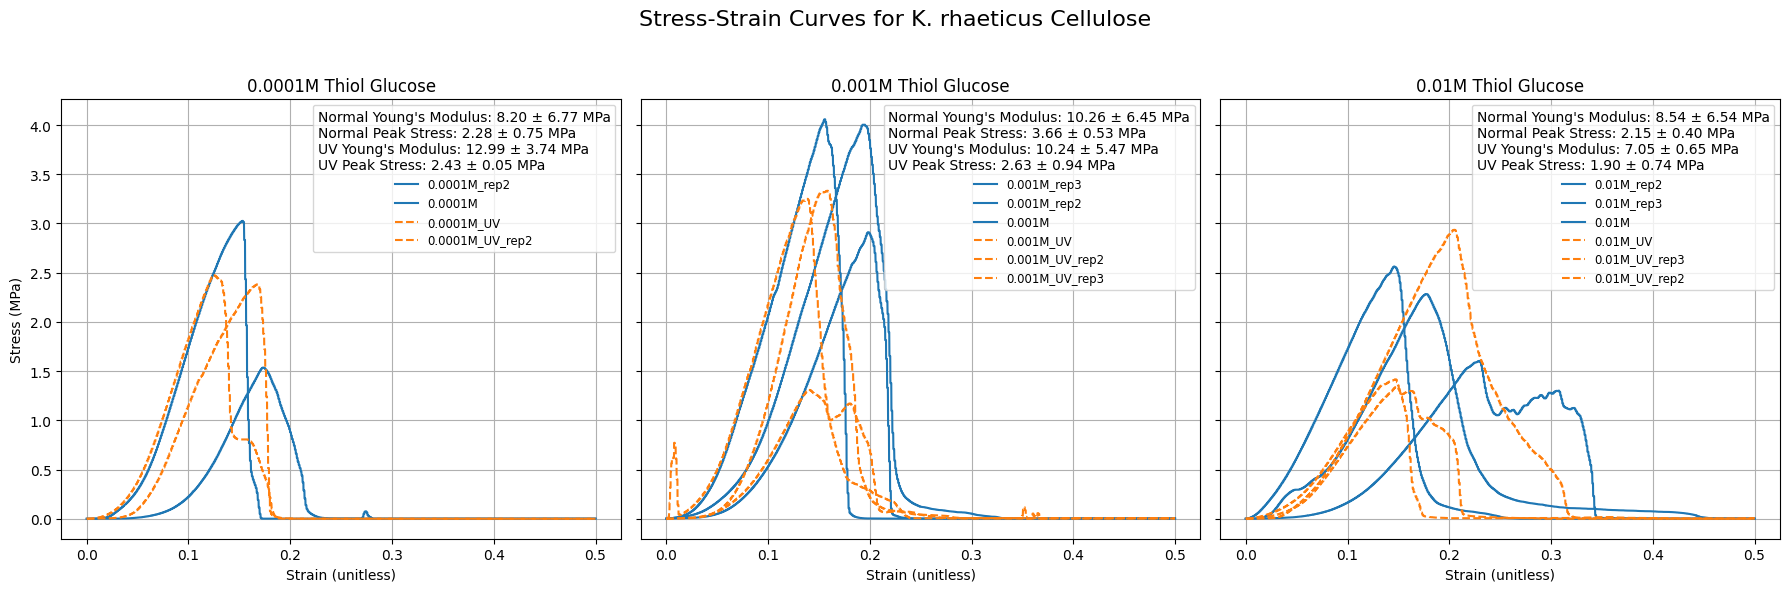

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from collections import defaultdict
from scipy.stats import linregress
import numpy as np

# Constants
L0 = 10.0  # mm
A = 0.5e-6  # m²
folder_path = '07.10.25_thiol_glucose_experiments'
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# Clean and group filenames
def clean_name(filename):
    base = os.path.basename(filename).replace('.csv', '')
    return base.replace('07.10.25_krha-', '')

condition_files = defaultdict(list)
for file in csv_files:
    name = clean_name(file)
    condition = name.split('_rep')[0]
    condition_files[condition].append((file, name))

# Group into base concentrations
base_groups = defaultdict(dict)
for condition in condition_files:
    base = condition.replace('_UV', '')
    if condition.endswith('_UV'):
        base_groups[base]['UV'] = condition_files[condition]
    else:
        base_groups[base]['Normal'] = condition_files[condition]

# Prepare subplot grid
base_concs = sorted(base_groups.keys())
n = len(base_concs)
fig, axes = plt.subplots(1, n, figsize=(6 * n, 6), sharey=True)

# Ensure axes is always a list
if n == 1:
    axes = [axes]

# Loop through each base concentration and subplot
for ax, base_conc in zip(axes, base_concs):
    cond_dict = base_groups[base_conc]
    legend_entries = []

    for label_type, linestyle, color in [('Normal', '-', 'tab:blue'), ('UV', '--', 'tab:orange')]:
        if label_type in cond_dict:
            moduli = []
            peak_stresses = []

            for file, label in cond_dict[label_type]:
                df = pd.read_csv(file)
                df['Force (Newtons)'] = df['Force (Newtons)'].clip(lower=0)
                df['Strain'] = df['Distance (millimeters)'] / L0
                df['Stress (MPa)'] = df['Force (Newtons)'] / A / 1e6

                # Estimate Young's modulus from linear region
                linear_region = df[df['Strain'] <= 0.1]
                slope, _, _, _, _ = linregress(linear_region['Strain'], linear_region['Stress (MPa)'])
                moduli.append(slope)

                # Get peak stress
                peak_stress = df['Stress (MPa)'].max()
                peak_stresses.append(peak_stress)

                # Plot
                ax.plot(df['Strain'], df['Stress (MPa)'],
                        label=label, linestyle=linestyle, color=color)

            # Compute and store averages
            mean_mod = np.mean(moduli)
            std_mod = np.std(moduli)
            mean_peak = np.mean(peak_stresses)
            std_peak = np.std(peak_stresses)

            legend_entries.append(f"{label_type} Young's Modulus: {mean_mod:.2f} ± {std_mod:.2f} MPa")
            legend_entries.append(f"{label_type} Peak Stress: {mean_peak:.2f} ± {std_peak:.2f} MPa")

    # Axis formatting
    ax.set_xlabel('Strain (unitless)')
    ax.set_title(f'{base_conc} Thiol Glucose')
    ax.grid(True)
    ax.legend(fontsize='small', loc='upper right', title='\n'.join(legend_entries))

# Shared Y-axis label
axes[0].set_ylabel('Stress (MPa)')
fig.suptitle("Stress-Strain Curves for K. rhaeticus Cellulose", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
